In [1]:
import tensorflow as tf
import keras
from keras import layers

import gym

import math
import os
import random
import time
import numpy as np

import matplotlib.pyplot as plt
import skimage.transform

from collections import namedtuple, deque
from itertools import count

from IPython import display

In [2]:
Experience = namedtuple(typename='Experience', field_names=('state', 'action', 'next_state', 'reward'))

In [3]:
class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def push(self, experience: Experience):
        self.memory.append(experience)

    def sample(self, batch_size: int) -> list[Experience]:
        return random.sample(self.memory, batch_size)
    
    def can_provide_sample(self, batch_size: int) -> bool:
        return len(self) >= batch_size

    def __len__(self) -> int:
        return len(self.memory)

In [4]:
class EpsilonGreedyStrategy:
    def __init__(self, start: float, end: float, decay: float):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step: int) -> float:
        return EpsilonGreedyStrategy.exploration_rate(self.start, self.end, self.decay, current_step)
    
    def __call__(self, current_step: int) -> float:
        return self.get_exploration_rate(current_step)

    @staticmethod
    def exploration_rate(start: float, end: float, decay: float, current_step: int):
        return end + (start - end) * math.exp(-1 * current_step * decay)

In [10]:
def get_curent_screen(env: gym.Env, resize: tuple[int, int]) -> tuple[np.ndarray, tf.Tensor]:
    env.render_mode = 'rgb_array'
    screen = env.render()
    env.render_mode = 'human'
    full_screen = screen.copy()
    screen_height = screen.shape[0]
    top = int(screen_height * .4)
    bottom = int(screen_height * .8)
    cropped = screen[top:bottom, :, :]
    resized = skimage.transform.resize(cropped, resize, anti_aliasing=True)
    return full_screen, tf.convert_to_tensor(resized)

In [6]:
def get_next_q_max(target_net: keras.Model, next_states: tf.Tensor) -> tf.Tensor:
    max_values = tf.reduce_max(next_states, axis=(1, 2, 3))  # Calculate max along inner dimensions
    not_finished = max_values > 0.0
    non_final_states = tf.boolean_mask(next_states, not_finished)
    batch_size = tf.shape(next_states)[0]
    values = tf.zeros(batch_size, dtype=tf.float32)
    
    if tf.reduce_any(not_finished):
        max_q_values = tf.reduce_max(target_net(non_final_states), axis=1)
        invalid_indices = tf.where(not_finished)  # Get the indices where not_finished is True
        invalid_indices_expanded = tf.squeeze(invalid_indices, axis=1)  # Squeeze the indices to shape (num_false_positions,)
        values = tf.tensor_scatter_nd_update(values, invalid_indices_expanded[:, tf.newaxis], max_q_values)

    return values

In [7]:
def create_q_dnn_model(img_height: int, img_weight: int) -> keras.Sequential:
    model = keras.Sequential((
        layers.Flatten(input_shape=(img_height, img_weight, 3)),
        layers.Dense(units=128, activation='relu'),
        layers.Dense(units=64, activation='relu'),
        layers.Dense(units=32, activation='relu'),
        layers.Dense(units=2),
    ))
    return model

In [3]:
def extract_tensors(experiences: list[Experience]) -> tuple[tf.Tensor, tf.Tensor, tf.Tensor, tf.Tensor]:
    batch = Experience(*zip(*experiences))
    t1 = tf.convert_to_tensor(batch.state)
    t2 = tf.convert_to_tensor(batch.action)
    t3 = tf.convert_to_tensor(batch.reward)
    t4 = tf.convert_to_tensor(batch.next_state)
    return t1, t2, t3, t4

In [4]:
def plot(episode_durations: list[int], title: str):
    plt.figure(1)
    plt.clf()
    plt.title(title)
    plt.xlabel('episodes')
    plt.ylabel('duration')
    plt.plot(episode_durations)
    plt.pause(.001)
    display.clear_output(wait=True)

In [5]:
batch_size = 256
gamma = .999
eps_start = 1
eps_end = .01
eps_decay = .001
target_update = 10
memory_size = 100_000
lr = .001
num_episodes = 1000
image_height, image_width = 40, 90

In [11]:
memory = ReplayMemory(memory_size)
epsilon_strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

policy_net = create_q_dnn_model(image_height, image_width)
# policy_net.compile()

target_net = create_q_dnn_model(image_height, image_width)
target_net.set_weights(policy_net.get_weights())
# target_net.compile()

target_net.trainable = False

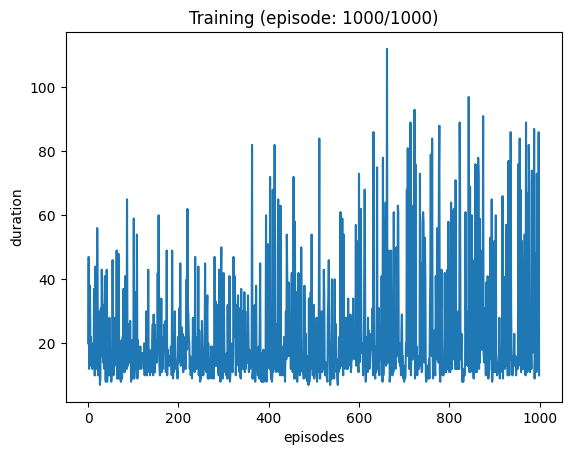

In [13]:
env = gym.make('CartPole-v1', render_mode='human').unwrapped

timestep_limit = 3500
cur_step = 0
episode_durations = list()

get_state = lambda: get_curent_screen(env, (image_height, image_width))

for episode in range(num_episodes):
    env.reset()
    current_screen = None
    done = False

    full_screen, current_screen = get_state()
    state = tf.zeros_like(current_screen)
    
    # time.sleep(1)
    for timestep in count():
        env.render()

        if epsilon_strategy(cur_step) > random.random():
            action = random.randrange(2)
        else:
            state_tensor = tf.convert_to_tensor([state])
            action = policy_net(state_tensor).numpy().argmax(axis=1)[0]
        cur_step += 1

        _, reward, done, truncated, info = env.step(action)
        done = done if timestep < timestep_limit else True
        if done:
            full_screen, current_screen = get_state()
            next_state = tf.zeros_like(current_screen)
        else:
            s1 = current_screen
            full_screen, s2 = get_state()
            current_screen = s2
            next_state = s1 - s2

        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            with tf.GradientTape() as tape:
                experiences = memory.sample(batch_size)
                states, actions, rewards, next_states = extract_tensors(experiences)

                actions = tf.expand_dims(actions, axis=-1)
                current_q_values = tf.gather(policy_net(states), actions, batch_dims=1)
                next_q_values = get_next_q_max(target_net, next_states)
                target_q_values = (next_q_values * gamma) + rewards

                loss = tf.keras.losses.MeanSquaredError()(current_q_values, tf.expand_dims(target_q_values, axis=-1))

            gradients = tape.gradient(loss, policy_net.trainable_variables)
            optimizer.apply_gradients(zip(gradients, policy_net.trainable_variables))

        if done:
            episode_durations.append(timestep)
            plot(episode_durations, title=f'Training (episode: {episode + 1}/{num_episodes})')
            break
    
    if episode % target_update == 0:
        target_net.set_weights(policy_net.get_weights())

In [14]:
env.close()

In [6]:
models_path = 'cart_pole_tf_2'
model_appendix = '_%d' % num_episodes
policy_net_path = models_path + '/policy_net' + model_appendix
target_net_path = models_path + '/target_net' + model_appendix

In [16]:
if not os.path.exists(models_path): os.mkdir(models_path)
policy_net.save(policy_net_path)
target_net.save(target_net_path)

INFO:tensorflow:Assets written to: cart_pole_tf_2/policy_net_1000\assets
INFO:tensorflow:Assets written to: cart_pole_tf_2/target_net_1000\assets


In [7]:
policy_net = keras.models.load_model(policy_net_path, compile=False)
target_net = keras.models.load_model(target_net_path, compile=False)

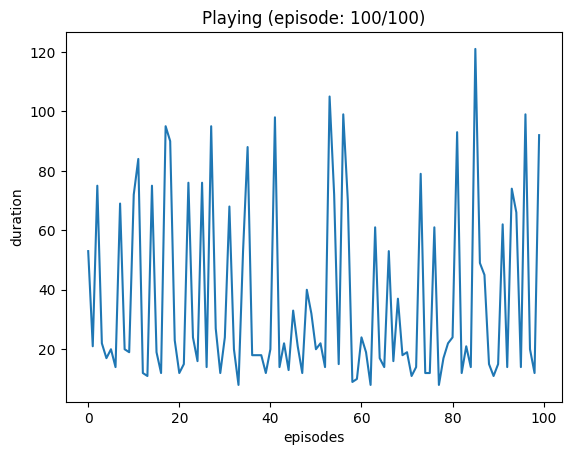

In [11]:
env = gym.make('CartPole-v1', render_mode='human').unwrapped

episodes_to_play = 100
timestep_limit = 3500
episode_durations = list()

get_state = lambda: get_curent_screen(env, (image_height, image_width))

for episode in range(episodes_to_play):
    env.reset()
    current_screen = None
    done = False

    full_screen, current_screen = get_state()
    state = tf.zeros_like(current_screen)
    
    # time.sleep(1)
    for timestep in count():
        env.render()

        state_tensor = tf.convert_to_tensor([state])
        action = policy_net.predict(state_tensor, verbose=0).argmax(axis=1)[0]

        _, reward, done, truncated, info = env.step(action)
        done = done if timestep < timestep_limit else True
        if done:
            full_screen, current_screen = get_state()
            next_state = tf.zeros_like(current_screen)
        else:
            s1 = current_screen
            full_screen, s2 = get_state()
            current_screen = s2
            next_state = s1 - s2

        state = next_state

        if done:
            episode_durations.append(timestep)
            plot(episode_durations, title=f'Playing (episode: {episode + 1}/{episodes_to_play})')
            break

In [19]:
env.close()